In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec
#!pip install contractions
import contractions
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('omw-1.4')
from nltk.corpus import stopwords
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip
import torch
import torch.nn as nn
# !pip install torchmetrics
import torchmetrics
from torchmetrics import F1Score
from torchmetrics import Accuracy
from torchmetrics import Precision
from torchmetrics import Recall
from torchmetrics import ROC
from torchmetrics.classification import BinaryROC

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
import string

In [ ]:
df = pd.read_csv('drive/MyDrive/imdb-reviews.csv', sep='\t')

# download trained model
model = torch.jit.load('myNN.pt')

test_df = None

df

#Pre-Processing

In [ ]:
def remove_cols(df):
  # διώχνω τα άχρηστα δεδομένα πχ. url rating
  df = df.drop(['url'], axis=1)

  # add sentiment col 0 for negative 1 for positive
  df['sentiment'] = np.where(df['rating']>4.0, 1, 0)

  # no more need for col rating
  df = df.drop(['rating'], axis=1)

  return df

df = remove_cols(df)

if test_df is not None:
  test_df = remove_cols(test_df)

In [ ]:
df['review'] = df['review'].str.lower()
df['review'] = df['review'].replace('<br />', ' ', regex=True)
df['review'] = df['review'].replace('<[^<]+?>', '', regex=True)

if test_df is not None:
  test_df['review'] = test_df['review'].str.lower()
  test_df['review'] = test_df['review'].replace('<br />', ' ', regex=True)
  test_df['review'] = test_df['review'].replace('<[^<]+?>', '', regex=True)

def clean_review(review):
  review = re.sub(r'[^a-zA-Z0-9\s]', '', review)

  return review

df['review'] = df['review'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

df['review'] = df['review'].apply(lambda x: clean_review(x))

if test_df is not None:
  test_df['review'] = test_df['review'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

  test_df['review'] = test_df['review'].apply(lambda x: clean_review(x))

df

In [ ]:
def expand_contractions(review):
  return contractions.fix(review)

df['review'] = df['review'].apply(lambda x: expand_contractions(x))

if test_df is not None:
  test_df['review'] = test_df['review'].apply(lambda x: expand_contractions(x))

df

In [ ]:
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)  # dictionary for faster lookup

def remove_stopwords(review):
  return ' '.join([word for word in review.split() if word not in stopwords_dict])

df['review'] = df['review'].apply(lambda x: remove_stopwords(x))

if test_df is not None:
  test_df['review'] = test_df['review'].apply(lambda x: remove_stopwords(x))

In [ ]:
def remove_dups(review):
  return ' '.join(dict.fromkeys(review.split()))

df['review'] = df['review'].apply(lambda x: remove_dups(x))

if test_df is not None:
  test_df['review'] = test_df['review'].apply(lambda x: remove_dups(x))

In [ ]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatization(review):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in tokenizer.tokenize(review)])

df['review'] = df['review'].apply(lemmatization)

if test_df is not None:
  test_df['review'] = test_df['review'].apply(lemmatization)

df

In [ ]:
dim = 300

if dim == 50:
  glove_input_file = 'glove.6B.50d.txt'

if dim == 300:
  glove_input_file = 'glove.6B.300d.txt'

w2v_output_file = 'glv_with_w2v_format.txt'



glove2word2vec(glove_input_file, w2v_output_file)

In [ ]:
with open(w2v_output_file, 'r') as infile:
    w2v = infile.read().splitlines()

words = []      # list of words
vectors = []    # holds the vector of corresponding word
index = 0       # index of word in list of vectors
dictionary = {} # word: , index_in_vectors:

# first element of w2v is 400000,50 so we dont need that
for word_vector_pair in w2v[1:]:
    word_vector_pair = word_vector_pair.split()
    words.append(word_vector_pair[0])           # add word in list
    vectors.append(np.array(word_vector_pair[1:]).astype(float))        # add vector in list (need to convert for later)
    dictionary[word_vector_pair[0]] = index     # update dictionary
    index += 1
print(type(vectors[0][0]))
word_vector = {w: vectors[dictionary[w]] for w in words}

In [ ]:
def create_review_vector(df, word_vector, dim):
  review_vectors = []  # list with mean vector values of each review
  for review in df['review']:
    words = review.split(' ')
    words_in_glove = 0   # number of words in review
    review_vector_mean = np.zeros((len(words),dim))           # we are going to add all the word vectors in review (that also exist in glove)
    i=0
    for word in words:
      if word in word_vector:
        review_vector_mean[i] += word_vector[word]
        words_in_glove += 1
      i+=1
    # we now have number of words in review and number of words also in glove
    mean = np.sum(review_vector_mean, axis=0)
    mean /= words_in_glove
    review_vectors.append(mean)

  return review_vectors

review_vectors = create_review_vector(df, word_vector, dim)

print(len(review_vectors))
print(len(review_vectors[0]))

In [ ]:
y1 = df['sentiment'].apply(lambda x: float(x))  # must convert for y_pred = model(x_batch)
y1 = y1.to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(np.array(review_vectors), y1, test_size = 0.1, random_state=42)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

Y_train = torch.squeeze(torch.from_numpy(Y_train))
Y_test = torch.squeeze(torch.from_numpy(Y_test))

if test_df is not None:

  x_val =
  y1_val = test_df['sentiment'].apply(lambda x: float(x))  # must convert for y_pred = model(x_batch)
  y1_val = y1_val.to_numpy()
  # y_test_val = torch.squeeze(torch.from_numpy(y1_val))
  # print(y_test_val.shape)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

#RNN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

In [ ]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()

        cells = {
          "RNN" : nn.RNN,
          "LSTM"    : nn.LSTM,
          "GRU"     : nn.GRU
        }
        self.cell_type = cell_type
        self.rnn = cells[cell_type](         # Pick the specific model
            input_size=input_size,    # Number of features for each time step
            hidden_size=hidden_size,  # rnn hidden units
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,          # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        # self.linear = nn.Linear(hidden_size*2, output_size) # Feed forward network

        self.linear = nn.Linear(hidden_size*2,64)
        self.linear2 = nn.Linear(64, output_size)

        self.out = nn.Sigmoid()

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)

        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)

        h1 = self.linear(r_out)
        h2 = self.linear2(h1)
        out = self.out(h2)

        return out.squeeze()

        # choose r_out at the last time step
        # out = self.out(r_out[:, -1])

        # return out


Hyperparameters

In [ ]:
# hyperparameters
# input_size = dim
# hidden_size = 64
# output_size = 1
# cell_type = 'LSTM'
# epochs = 10
# num_layers = 3
# learning_rate = 0.001

# model = RNN(cell_type, input_size, hidden_size, output_size, num_layers)
# print(model)

# # Initialization of optimizer and loss function
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.BCELoss()

# # Transfer all the computation to GPU (cuda device).
# model = model.to(device)
# criterion = criterion.to(device)

#Initialise dataloader
dataset = torch.utils.data.TensorDataset(X_train, Y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)

#initialise test dataloader
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

Train

In [ ]:
from sklearn import metrics

f1_score = F1Score(task="binary", num_classes=1)
acc = Accuracy(task="binary", num_classes=1)
rec = Recall(task="binary", num_classes=1)
prec = Precision(task="binary", num_classes=1)

# train_mean_accuracy = []
# train_mean_loss = []
# train_mean_roc = []
# train_mean_fpr = []
# train_mean_tpr = []
# train_mean_thresholds = []

# test_mean_accuracy = []
# test_mean_loss = []
# test_mean_fpr = []
# test_mean_tpr = []
# test_mean_thresholds = []

# clip = 5

# test_size = 1000
# #start train mode
# model.train()

# for epoch in range(epochs):
#   batch_losses = []
#   accuracy = []
#   precision = []
#   recall = []
#   f1 = []
#   fpr_list = []
#   tpr_list = []
#   thresholds_list = []
#   test_batch_losses = []
#   test_accuracy = []
#   test_precision = []
#   test_recall = []
#   test_f1 = []
#   test_fpr_list = []
#   test_tpr_list = []
#   test_thresholds_list = []
#   for x_batch, y_batch in dataloader:
#     x_batch = x_batch.to(torch.float32)
#     y_batch = y_batch.to(torch.float32)

#     #clear gradients for this step
#     optimizer.zero_grad()

#     y_pred = model(x_batch)

#     loss = criterion(y_pred, y_batch)

#     batch_losses.append(loss.item())
#     precision.append(prec(torch.squeeze(torch.round(y_pred)), y_batch))
#     accuracy.append(acc(torch.squeeze(torch.round(y_pred)), y_batch))
#     f1.append(f1_score(torch.squeeze(torch.round(y_pred)), y_batch))
#     recall.append(rec(torch.squeeze(torch.round(y_pred)), y_batch))

#     loss.backward()

#     nn.utils.clip_grad_norm_(model.parameters(), clip)

#     optimizer.step()

#   for test_x, test_y in test_dataloader:
#     test_x = test_x.to(torch.float32)
#     test_y = test_y.to(torch.float32)

#     y_pred = model(test_x)

#     loss = criterion(y_pred, test_y)
#     test_batch_losses.append(loss.item())

#     test_precision.append(prec(torch.squeeze(torch.round(y_pred)), test_y))
#     test_accuracy.append(acc(torch.squeeze(torch.round(y_pred)), test_y))
#     test_f1.append(f1_score(torch.squeeze(torch.round(y_pred)), test_y))
#     test_recall.append(rec(torch.squeeze(torch.round(y_pred)), test_y))

#     fpr, tpr, thresholds = metrics.roc_curve(np.round_(y_pred.detach().numpy()), test_y, pos_label=1)
#     fpr_list.append(fpr)
#     tpr_list.append(tpr)
#     thresholds_list.append(thresholds)

#   train_mean_accuracy.append(sum(accuracy)/len(dataloader))
#   test_mean_accuracy.append(sum(test_accuracy)/len(test_dataloader))
#   train_mean_loss.append(sum(batch_losses)/len(dataloader))
#   test_mean_loss.append(sum(test_batch_losses)/len(test_dataloader))

#   test_mean_fpr.append(sum(fpr_list)/len(test_dataloader))
#   test_mean_tpr.append(sum(tpr_list)/len(test_dataloader))

#   print(f"Epoch {epoch:3}: Accuracy = {sum(accuracy)/len(dataloader):.5f} -  Test Accuracy = {sum(test_accuracy)/len(test_dataloader):.5f}")
#   print(f"Epoch {epoch:3}: Precision = {sum(precision)/len(dataloader):.5f} -  Test Precision = {sum(test_precision)/len(test_dataloader):.5f}")
#   print(f"Epoch {epoch:3}: Recall = {sum(recall)/len(dataloader):.5f} -  Test Recall = {sum(test_recall)/len(test_dataloader):.5f}")
#   print(f"Epoch {epoch:3}: F1 = {sum(f1)/len(dataloader):.5f} -  Test F1 = {sum(test_f1)/len(test_dataloader):.5f}")
#   print(f"Epoch {epoch:3}: Test Fpr = {sum(fpr_list)/len(test_dataloader)}")
#   print(f"Epoch {epoch:3}: Test Tpr = {sum(tpr_list)/len(test_dataloader)}")
#   print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader):.5f} -  Test Loss = {sum(test_batch_losses)/len(test_dataloader):.5f}")
#   print()

Plot

In [ ]:
def plot_lc(train, test, title, ylabel, loc):
  figure(figsize=(8,8))
  plt.plot(train)
  plt.plot(test)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel("Epoch")
  plt.legend(['train', 'test'], loc=loc)
  plt.show()

# plot_lc(train_mean_accuracy, test_mean_accuracy, "Learning Curve Accuracy", "Accuracy", 'lower right')
# print()
# plot_lc(train_mean_loss, test_mean_loss, "Learning Curve Loss", "Loss", 'upper right')

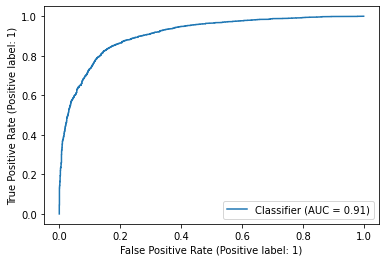

In [ ]:
y_pred = model(X_test.float())
display = metrics.RocCurveDisplay.from_predictions(Y_test, y_pred.detach().numpy())

In [ ]:
# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('myNN.pt') # Save


evaluate on test

In [ ]:
if test_df is not None:
  val_review_vectors = create_review_vector(test_df, word_vector, dim)

  x_val = np.array(val_review_vectors)
  x_val = torch.tensor(x_val)
  y_pred = model(x_val.float().clone().detach().requires_grad_(True))
  y1_val = torch.squeeze(torch.from_numpy(y1_val))

  print(prec(torch.squeeze(torch.round(y_pred)), y1_val))
  print(acc(torch.squeeze(torch.round(y_pred)), y1_val))
  print(f1_score(torch.squeeze(torch.round(y_pred)), y1_val))
  print(rec(torch.squeeze(torch.round(y_pred)), y1_val))